# Distillation Explainer

Distillation is a critical technique towards improving a network's quality while keeping its serving latency constant.

![distill picture](distill.png)

This is becoming crucial as people focus on serving larger and larger models. Image found on [LinkedIn](https://www.linkedin.com/pulse/model-compression-knowledge-distillation-swapnil-kangralkar-j8dbc/).

Distillation is a powerful technique, but a couple things about it are quite mystical. The purpose of this post is to:

1. Provide a very high level explainer (but mostly refer to source papers) of distillation.
2. Show that you can create a **simple, linear example** where distillation works.


## How is distillation implemented?

At an algorithmic level, distillation, introduced by [Hinton, Vinyals, and Dean 2015](https://arxiv.org/abs/1503.02531), applied to a classification problem with labels $y=1,\cdots,d$ proceeds as follows.

1. Train a large, expensive teacher network $T(x;\mu)$ to predict the distribution $y|x$ (a categorical distribution on $[d]$, $\Delta_d$) from a large dataset of $(x, y)$ pairs; this is done by minimizing negative log-likelihood (NLL) of the teacher's prediction $\min_\mu -\log T(x; \mu)_y$, yielding $\mu_*$.
2. Train your smaller, cheaper network $S(x;\theta)$ on a combined loss from the data NLL and matching the teacher distribution by minimzing cross-entropy $H(S(x;\theta)||T(x;\mu_*))=-\sum_{i=1}^d T(x; \mu_*)\log S(x; \theta)$, i.e., $\min_\theta =  -\log S(x; \theta)_y + \alpha H(S(x;\theta)||T(x;\mu_*)))(x)$. Since $\mu_*$ is fixed, optimizing the latter term is equivalent to minimizing $D_{\mathrm{KL}}(S||T)$, where $\alpha$ is some hyper.

This has been scaled up to language models too, see [Anil et al 2018](https://arxiv.org/abs/1804.03235).

## Why woudn't it work?

At first, I found the fact that distillation helps mind-bending. To understand why I was confused, let's look at the distillation loss for $\theta$:

$$
-\log S(x; \theta)_y + \alpha H(S(x;\theta)||T(x;\mu_*)) = c_\alpha H\left(S(x;\theta)\bigg|\bigg|\frac{\delta_y +\alpha T(x;\mu_*)}{1+\alpha}\right)
$$

That is, distillation loss is, up to a constant $c_\alpha$, equivalent to softening our data label $y$ by the teacher's predictions $T(x;\mu_*)$

We started with a dataset. Ran it through some matmuls, $T(x;\mu_*)$. So if we view the dataset as a huge random variable (rv) $D$, $\mu_*$ and indeed $T(x;\mu_*)$ is just some other rv which is a very complicated function of $D$ (since they resulted from SGD or some training process applied to $D$).

So we just took our clean labels $y$ and added noise to them! And it helped! Indeed, we can formalize this concern in the case $\alpha=\infty$ (so that the distillation label $y'=T(x;\mu_*)$. In practice, and even in the linear setting I discuss next, this still works, in that train and test loss improve over using $y$.

If we train with just $y'$ then the training process forms a Markov chain conditioned on all $x$: $y \rightarrow \mu_*\rightarrow \theta_*$ (given $\mu_*$, and therefore $y'$, the training of $\theta_*$ is conditionally independent of $y$).

Then by the [data processing inequality](https://en.wikipedia.org/wiki/Data_processing_inequality), the mutual information $I(y, \mu_*)\ge I_{\alpha=\infty}(y, \theta_*)$. There's no paradox here, obviously, since distillation works, but it feels wrong to distance ourselves from the true label. We don't know the relationship between $ I_{\alpha=\infty}(y, \theta_*)$ and $ I_{\alpha=0}(y, \theta_*)$ but this seems like a step in the wrong direction.

This concern could be framed as an invocation [Vapnik's principle](https://unknowngenius.com/blog/archives/2010/11/24/vapniks-principle/): "When solving a problem of interest, do not solve a more general problem as an intermediate step."

## Why does it work?

In short, it can be the case that $ I_{\alpha=\infty}(y, \theta_*) > I_{\alpha=0}(y, \theta_*)$ because of variance reduction. The teacher makes the labels less noisy.

The underlying classification problem has $(X, Y)\sim\mathcal{D}$ where noisy $Y|X$ is still stochastic. One can imagine that for a logistic loss, the variance of the training loss from $n$ examples derived from the dataset $(X, \mathbb{E}[Y|X])$ is smaller than that of the training loss from $n$ examples of $(X, Y)$. For a probabilistic binary model $p_\theta$ parameterized by $\theta$:

$$
\mathrm{var}\ \frac{1}{n}\sum_i\log(1+\exp(-Y_ip_\theta(X_i)))\ge \mathrm{var}\ \frac{1}{n}\sum_i\log(1+\exp(-\mathbb{E}[Y_i|X_i]p_\theta(x_i)))\,\,,
$$
where this holds by Jensen and the fact that log loss is convex (note this still holds for neural nets $p_\theta$)

So if instead of $\mathbb{E}[Y|X]$ we use a larger neural network teacher $\hat f(X)\approx \mathbb{E}[Y|X]$, so long as the _teacher itself_ does not add more variance, then knowledge distillation can indeed be useful.

The below shows a non-deep simple example in the low-data setting where this matters, but again, we rely on the fact that the teacher has a strong inductive bias so that the last caveat is met.


In [2]:
import numpy as np
from sklearn.base import clone
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from scipy.special import expit
from sklearn.metrics import log_loss

In [3]:
def base_distribution(rng, n):
  x = rng.standard_normal(n) * 10
  ey = 0.4 * np.sin(x) + 0.5
  y = rng.binomial(1, ey)
  return x[:, np.newaxis], y

In [4]:
def run_kd(num_training_ex, x, y):
  test_prop = 1 - num_training_ex / len(x)
  xtr, xte, ytr, yte = train_test_split(x, y, test_size=test_prop, random_state=42)

  # Student is from a model class that won't be able to reconstruct the ground
  # truth
  degree = 3
  student = make_pipeline(
      PolynomialFeatures(degree),
      LogisticRegression(max_iter=1000))

  # Teacher comes from a better model class
  teacher = make_pipeline(
      FunctionTransformer(np.sin),
      LogisticRegression(max_iter=1000))

  student.fit(xtr, ytr)
  teacher.fit(xtr, ytr)

  teacher_labels = teacher.decision_function(xtr)

  # Hack to train on soft targets
  # https://stackoverflow.com/a/60969923

  distilled = make_pipeline(
      PolynomialFeatures(degree),
      LinearRegression())

  distilled.fit(xtr, teacher_labels)
  distilled.decision_function = distilled.predict

  models = {'student': student, 'teacher': teacher, 'distilled': distilled}
  datasets = {'train': (xtr, ytr), 'test': (xte, yte)}

  results = {}

  for model_name, model in models.items():
    # print(model_name)
    for split_name, (x, y) in datasets.items():
      pred = model.decision_function(x)
      pred = expit(pred)
      # print('  {:10} {:.4f}'.format(split_name, log_loss(y, pred)))
      results[model_name + '.' + split_name] = log_loss(y, pred)

  return results

In [5]:
results = None
ntrials = 15
import jax
nexs = np.arange(10, 50, 5, int)
for nex in nexs:
  rng = np.random.default_rng(1234)
  trials = [run_kd(nex, *base_distribution(rng, 10000)) for _ in range(ntrials)]
  # List of dicts to dict of singleton list of average
  run = jax.tree_map(lambda *xs: [np.mean(xs)], *trials)
  results = run if not results else {k: results[k] + run[k] for k in results}

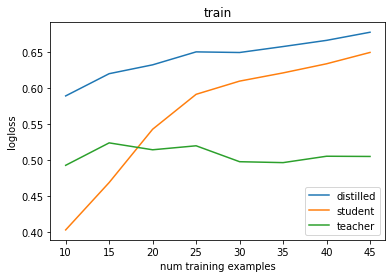

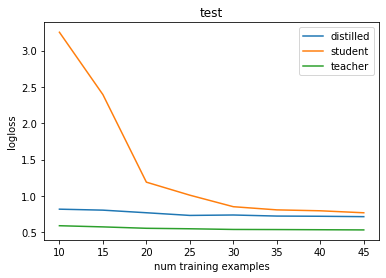

In [6]:
from matplotlib import pyplot as plt

for split in ['train', 'test']:
  for k, v in results.items():
    if split in k:
      plt.plot(nexs, v, label=k.replace('.' + split, ''))
  plt.legend()
  plt.title(split)
  plt.xlabel('num training examples')
  plt.ylabel('logloss')
  plt.show()

## Is that all there is to it?

Not quite. With neural nets, we do see some really intersting training phenomena not fully accounted for by the story above. For instance, self-distillation (where the "teacher" is the same size as the student) somehow _works_!

There are interactions with imperfect non-convex optimization in the deep neural network setting which are still a research topic. For more, check out a [Zeyuan Allen-Zhu and Yuanzhi Li blog post from MSR](https://www.microsoft.com/en-us/research/blog/three-mysteries-in-deep-learning-ensemble-knowledge-distillation-and-self-distillation/)